In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelForCausalLM
from tqdm import tqdm
import torch as torch
from datasets import load_dataset, load_from_disk
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import pickle
from scipy.optimize import curve_fit

from superurop.utilities.utils import *

dataset_manager = DatasetManager()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Find the parameters over a natural dataset
Collect vocab distribution (easy), fourgram entropy, and fourgram token_distribution over a natural dataset using a pretrained model.

In [57]:
def get_vocab_distribution(dataset):
    vocab_distribution = np.zeros(50256)
    for i in tqdm(range(len(dataset))):
        text = dataset[i]
        input_ids = tokenizer.encode(text)
        for id in input_ids:
            vocab_distribution[id] += 1
    vocab_distribution = vocab_distribution / np.sum(vocab_distribution)
    return vocab_distribution

def get_four_gram_stats(dataset):
    # model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b").to(device)
    model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
    model.eval()
    three_gram_tensor = []
    for i in range(len(dataset)):
        text = tokenizer.encode(dataset[i])
        for j in range(len(text) - 3):
            three_gram_tensor.append(text[j:j+3])
    three_gram_tensor = torch.tensor(three_gram_tensor).to(device)
    batch_size = 32
    cutoff = len(three_gram_tensor) // batch_size * batch_size
    three_gram_tensor = three_gram_tensor[:cutoff]
    three_gram_tensor = three_gram_tensor.view(-1, batch_size, 3)
        
    top_logits = []
    for input in tqdm(three_gram_tensor):
        logits = model(input).logits[:, -1, :]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        probs, indices = torch.topk(probs, 10)
        probs = probs.flatten()
        top_logits.extend(probs.cpu().detach().numpy().tolist())
    top_logits = np.array(top_logits)
    return top_logits
        

In [59]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)

In [60]:
vocab_distribution = np.sort(get_vocab_distribution(data))[::-1]
four_gram_completion_dist = get_four_gram_stats(data)
binned_four_gram_stats = np.histogram(four_gram_completion_dist, bins=1000, range=(0, 1), density=False)[0]

100%|██████████| 2255/2255 [00:29<00:00, 77.38it/s]


In [61]:
def exp_with_gaussian_rise(x, a, b, d, sigma):
    return a * np.exp(-b * x) + d * np.exp(-((x - 1)**2) / (2 * sigma**2))

def exponential(x, a, b, c, d, e):
    return a * np.exp(-b * x) + c * np.exp(-d * x) + e

In [62]:
def fit_distribution(distribution, x, func, p0=None):
    distribution = distribution / np.sum(distribution)
    popt, pcov = curve_fit(func, x, distribution, p0=p0)

    y_fit = func(x, *popt)
    plt.plot(x, distribution, 'b-', label='data')
    plt.plot(x, y_fit, 'r-', label='fit')
    plt.legend()
    plt.show()

    return popt

In [471]:
vocab_multipliers = {"l": 0.02, "m": 1, "h": 10}
next_token_multipliers = {"l": 2, "m": 1, "h": 0.5}

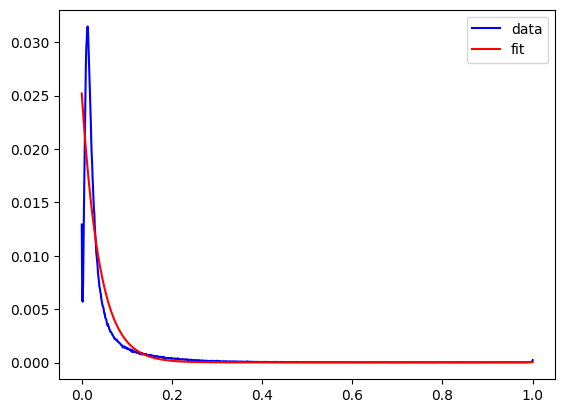

/tmp/ipykernel_1290703/918606255.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c * np.exp(-d * x) + e
/tmp/ipykernel_1290703/918606255.py:5: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c * np.exp(-d * x) + e
/tmp/ipykernel_1290703/918606255.py:5: RuntimeWarning: invalid value encountered in add
  return a * np.exp(-b * x) + c * np.exp(-d * x) + e


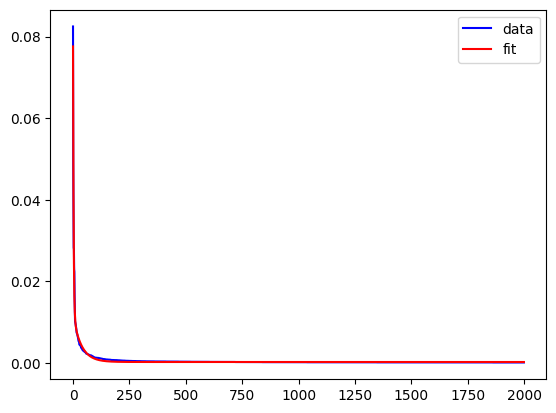

In [63]:
x = np.linspace(0, 1, len(binned_four_gram_stats))
next_token_dist_params = fit_distribution(binned_four_gram_stats, x, exp_with_gaussian_rise)
#rise is to increase probabilities at the end of the distribution, need to set these parameters by hand
next_token_dist_params[-1] = 0.1 #sigma
next_token_dist_params[-2] = 0.0001 #d
next_token_dist_params[1] = next_token_dist_params[1] * 0.9 #need the base curve a bit more distributed

x = np.arange(len(vocab_distribution[:2000]))
vocab_dist_params = fit_distribution(vocab_distribution[:2000], x, exponential, p0=None)

In [64]:
with open("/om2/user/jackking/superurop/scripts/base_next_token_dist_params.pkl", 'wb') as f:
    pickle.dump(next_token_dist_params, f)

with open("/om2/user/jackking/superurop/scripts/base_vocab_dist_params.pkl", 'wb') as f:
    pickle.dump(vocab_dist_params, f)

# Generate fourgram models using params

In [54]:
def consruct_fourgram_model_wrapper(next_token_dist, vocab_distribution, num_base_threegrams, tree_depth, buckets, vocab_size):
    fourgram_model = {}
    entropy = {}
    all_selected_tokens = []

    def construct_fourgram_model(threegram, threegram_prob, depth=0):
        tokens_dist = []
        while sum(tokens_dist) < 1:
            next_token_prob = np.random.choice(buckets, 1, p=next_token_dist)[0]
            if sum(tokens_dist) + next_token_prob > 1:
                next_token_prob = 1 - sum(tokens_dist)
            tokens_dist.append(next_token_prob)

        num_tokens = len(tokens_dist)
        tokens = np.random.choice(vocab_size, num_tokens, p=vocab_distribution)

        #if we are at the leaf node, only pick continuations that are in the model
        if depth == tree_depth:
            # already_selected_vocab_dist = vocab_distribution[:len(vocab_distribution)] / np.sum(vocab_distribution[:len(vocab_distribution)])
            # tokens = np.random.choice(vocab_size, num_tokens, p=already_selected_vocab_dist)
            cycle_tokens = []
            cycle_tokens_dist = []
            for i in range(num_tokens):
                new_threegram = threegram[1:] + (tokens[i],)
                if new_threegram in fourgram_model:
                    cycle_tokens.append(tokens[i])
                    cycle_tokens_dist.append(tokens_dist[i])
            if not len(cycle_tokens) == 0:
                tokens = cycle_tokens
                tokens_dist = cycle_tokens_dist / np.sum(cycle_tokens_dist)
            #if there is no possible continuation, just use previous tokens
            
        # else:
            # tokens = np.random.choice(vocab_size, num_tokens, p=vocab_distribution)
        
        # all_selected_tokens.extend(tokens)

        fourgram_model[threegram] = (tokens, tokens_dist)
        entropy[threegram] = -np.sum(tokens_dist * np.log(tokens_dist)) * threegram_prob

        if depth < tree_depth:
            for i in range(num_tokens):
                new_threegram = threegram[1:] + (tokens[i],)
                new_threegram_prob = threegram_prob * tokens_dist[i]
                construct_fourgram_model(new_threegram, new_threegram_prob, depth + 1)
    
    base_threegrams = np.random.choice(len(vocab_distribution), num_base_threegrams*3, p=vocab_distribution)
    base_threegrams = base_threegrams.reshape(-1, 3)
    for base_index in tqdm(range(num_base_threegrams)):
        base_threegram = base_threegrams[base_index]
        base_threegram = tuple(base_threegram)
        #probability of the base threegram
        threegram_prob = 1/num_base_threegrams
        construct_fourgram_model(base_threegram, threegram_prob)
    
    base_threegrams = [tuple(base_threegram) for base_threegram in base_threegrams]
    
    return fourgram_model, entropy, base_threegrams

In [ ]:
#generate a ton of fourgram models and check the entropy
base_next_token_dist_params = pickle.load(open("/om2/user/jackking/superurop/scripts/base_next_token_dist_params.pkl", 'rb'))
base_vocab_dist_params = pickle.load(open("/om2/user/jackking/superurop/scripts/base_vocab_dist_params.pkl", 'rb'))
buckets = np.linspace(0, 1, 1001)[1:]
vocab_size = 2000
# num_base_threegrams = 20
# tree_depth = 4
num_base_threegrams = 10
tree_depth = 3

entropy_matrix = np.zeros((3, 3))
for ntm, next_token_dist_multiplier in enumerate([1, 2, 0.5]):
    next_token_dist_params = base_next_token_dist_params.copy()
    next_token_dist_params[1] = base_next_token_dist_params[1] * next_token_dist_multiplier
    next_token_dist = exp_with_gaussian_rise(buckets, *next_token_dist_params)
    next_token_dist = next_token_dist / np.sum(next_token_dist)
    for vm, vocab_dist_multiplier in enumerate([0.02, 1, 10]):
        vocab_dist_params = base_vocab_dist_params.copy()
        vocab_dist_params[1] = base_vocab_dist_params[1] * vocab_dist_multiplier
        vocab_dist = exponential(np.arange(vocab_size), *vocab_dist_params)
        vocab_dist = vocab_dist / np.sum(vocab_dist)
        fourgram_model, entropy = consruct_fourgram_model_wrapper(next_token_dist, vocab_dist, num_base_threegrams, tree_depth, buckets)
        print(f"Next Token Multiplier: {next_token_dist_multiplier}, Vocab Multiplier: {vocab_dist_multiplier}")
        print(f"Entropy: {np.sum(list(entropy.values()))}")
        entropy_matrix[ntm, vm] = np.sum(list(entropy.values()))

In [451]:
entropy_matrix2[0][0] = 0.013971501311719162
entropy_matrix2[0][1] = 0.02651135868018111
entropy_matrix2[0][2] = 0.02757774729862998
entropy_matrix2[0][3] = 0.016134310195484978
entropy_matrix2[0][4] = 0.014158802715712269
entropy_matrix2[0][5] = 0.014400872742730518
entropy_matrix2[0][6] = 0.008329232041382837
entropy_matrix2[1][0] = 0.14513043305892925
entropy_matrix2[1][1] = 0.17668028122670973
entropy_matrix2[1][2] = 0.13062861164653047
entropy_matrix2[1][3] = 0.11051111196403546
entropy_matrix2[1][4] = 0.08656597301886745
entropy_matrix2[1][5] = 0.06535956780567821
entropy_matrix2[1][6] = 0.05862369450676458
entropy_matrix2[2][0] = 0.6920570508957882
entropy_matrix2[2][1] = 0.6236677155863951
entropy_matrix2[2][2] = 0.4356283164598164
entropy_matrix2[2][3] = 0.3546180144795724
entropy_matrix2[2][4] = 0.2971891357564433
entropy_matrix2[2][5] = 0.2732930561883583
entropy_matrix2[2][6] = 0.24262643085354194
entropy_matrix2[3][0] = 1.0886429407426137
entropy_matrix2[3][1] = 0.9262309535958325
entropy_matrix2[3][2] = 0.7080330677659677
entropy_matrix2[3][3] = 0.5966360626749223
entropy_matrix2[3][4] = 0.5428372420757956
entropy_matrix2[3][5] = 0.46004846596755
entropy_matrix2[3][6] = 0.43267115010573687
entropy_matrix2[4][0] = 1.4079778061490253
entropy_matrix2[4][1] = 1.146977678234076

In [36]:
vocab_multipliers = {"h": 0.02, "m": 1, "l": 10}
next_token_multipliers = {"h": 2, "m": 1, "l": 0.5}
base_next_token_dist_params = pickle.load(open("base_next_token_dist_params.pkl", 'rb'))
base_vocab_dist_params = pickle.load(open("base_vocab_dist_params.pkl", 'rb'))

def get_distributions(pv_dist, pnt_dist):
    vocab_dist_params = base_vocab_dist_params.copy()
    vocab_dist_params[1] = base_vocab_dist_params[1] * vocab_multipliers[pv_dist]
    vocab_dist = exponential(np.arange(vocab_size), *vocab_dist_params)
    vocab_dist = vocab_dist / np.sum(vocab_dist)

    next_token_dist_params = base_next_token_dist_params.copy()
    next_token_dist_params[1] = base_next_token_dist_params[1] * next_token_multipliers[pnt_dist]
    next_token_dist = exp_with_gaussian_rise(buckets, *next_token_dist_params)
    next_token_dist = next_token_dist / np.sum(next_token_dist)

    return vocab_dist, next_token_dist

In [34]:
print("2000")
vocab_size = 2000
num_base_threegrams = 1
tree_depth = 5
buckets = np.linspace(0, 1, 1001)[1:]
generator_type = "toy"
v_dist_level = "m"
nt_dist_level = "l"

for nt_dist_level in ["l", "m", "h"]:
    for v_dist_level in ["l", "m", "h"]:
        generator_name = f"v{v_dist_level}_nt{nt_dist_level}"

        vocab_dist, next_token_dist = get_distributions(v_dist_level, nt_dist_level)

        fourgram_model, entropy, base_threegrams = consruct_fourgram_model_wrapper(next_token_dist, vocab_dist, num_base_threegrams, tree_depth, buckets, vocab_size)

        params = {"vocab_size": vocab_size, "num_base_threegrams": num_base_threegrams, "tree_depth": tree_depth, "generator_type": generator_type, "generator_name": generator_name, "v_dist_level": v_dist_level, "nt_dist_level": nt_dist_level}

        dataset_manager.save_dataset_generator(generator_type, generator_name, fourgram_model, params)

        print(f"Next Token Multiplier: {next_token_multipliers[nt_dist_level]}, Vocab Multiplier: {vocab_multipliers[v_dist_level]}")
        print(f"Entropy: {np.sum(list(entropy.values()))}")

2000


100%|██████████| 1/1 [02:39<00:00, 159.73s/it]


Leaf count:  [220923]
Leaf in model count:  [20247]
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 10.714923205338097


100%|██████████| 1/1 [02:24<00:00, 144.29s/it]


Leaf count:  [205707]
Leaf in model count:  [29671]
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 11.46136420297109


100%|██████████| 1/1 [02:58<00:00, 178.69s/it]


Leaf count:  [255782]
Leaf in model count:  [7803]
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 12.296325015414943


100%|██████████| 1/1 [48:29<00:00, 2909.37s/it]


Leaf count:  [2597140]
Leaf in model count:  [485498]
Next Token Multiplier: 1, Vocab Multiplier: 10
Entropy: 11.706453890796181


  0%|          | 0/1 [01:04<?, ?it/s]


KeyboardInterrupt: 

In [28]:
print("200")
vocab_size = 200
num_base_threegrams = 1
tree_depth = 5
buckets = np.linspace(0, 1, 1001)[1:]
generator_type = "toy"
v_dist_level = "m"
nt_dist_level = "l"

for nt_dist_level in ["l", "m", "h"]:
    for v_dist_level in ["l", "m", "h"]:
        generator_name = f"v{v_dist_level}_nt{nt_dist_level}"

        vocab_dist, next_token_dist = get_distributions(v_dist_level, nt_dist_level)

        fourgram_model, entropy, base_threegrams = consruct_fourgram_model_wrapper(next_token_dist, vocab_dist, num_base_threegrams, tree_depth, buckets, vocab_size)

        params = {"vocab_size": vocab_size, "num_base_threegrams": num_base_threegrams, "tree_depth": tree_depth, "generator_type": generator_type, "generator_name": generator_name, "v_dist_level": v_dist_level, "nt_dist_level": nt_dist_level}

        dataset_manager.save_dataset_generator(generator_type, generator_name, fourgram_model, params)

        print(f"Next Token Multiplier: {next_token_multipliers[nt_dist_level]}, Vocab Multiplier: {vocab_multipliers[v_dist_level]}")
        print(f"Entropy: {np.sum(list(entropy.values()))}")

200


100%|██████████| 1/1 [02:14<00:00, 134.71s/it]


Leaf count:  2273109
Leaf in model count:  318440
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 9.426957971378787


100%|██████████| 1/1 [02:31<00:00, 151.19s/it]


Leaf count:  2542555
Leaf in model count:  453718
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 8.23755154246257


100%|██████████| 1/1 [02:53<00:00, 173.91s/it]


Leaf count:  2862627
Leaf in model count:  477235
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 12.068891171723987


100%|██████████| 1/1 [1:03:09<00:00, 3789.90s/it]


Leaf count:  6850386
Leaf in model count:  3363960
Next Token Multiplier: 1, Vocab Multiplier: 10
Entropy: 3.3191899595306986


100%|██████████| 1/1 [1:31:13<00:00, 5473.15s/it]


Leaf count:  12248043
Leaf in model count:  7771833
Next Token Multiplier: 1, Vocab Multiplier: 1
Entropy: 3.979164732203147


100%|██████████| 1/1 [1:25:39<00:00, 5139.54s/it]


Leaf count:  17011389
Leaf in model count:  9630885
Next Token Multiplier: 1, Vocab Multiplier: 0.02
Entropy: 6.619165927861312


100%|██████████| 1/1 [4:37:51<00:00, 16671.16s/it]


Leaf count:  28063375
Leaf in model count:  18829748
Next Token Multiplier: 2, Vocab Multiplier: 10
Entropy: 2.5743540194085996


100%|██████████| 1/1 [2:48:59<00:00, 10139.76s/it]


Leaf count:  34806703
Leaf in model count:  24480842
Next Token Multiplier: 2, Vocab Multiplier: 1
Entropy: 1.8075532073314151


  0%|          | 0/1 [37:33<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 10/10 [01:42<00:00, 10.29s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 9.350670574660485
100%|██████████| 10/10 [01:32<00:00,  9.25s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 8.85168403770368
100%|██████████| 10/10 [01:16<00:00,  7.65s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 9.8247713448935


100%|██████████| 10/10 [01:34<00:00,  9.47s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 8.910966385458398
100%|██████████| 10/10 [01:35<00:00,  9.54s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 8.866736048877026
100%|██████████| 10/10 [01:50<00:00, 11.03s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 10.14649454057585

  0%|          | 0/10 [00:00<?, ?it/s]
100%|██████████| 10/10 [01:45<00:00, 10.60s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 9.263555258985322
100%|██████████| 10/10 [01:27<00:00,  8.71s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 9.016028945721088
100%|██████████| 10/10 [01:28<00:00,  8.85s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 9.777010817924783

# Generate a random dataset using the fourgram models

In [55]:
def generate_dataset(generator, params, base_threegrams):
    num_samples = params["num_samples"]
    context_length = params["context_length"]
    vocab_size = params["vocab_size"]

    dataset = []
    entropy = 0
    count = 0

    for sample_idx in tqdm(range(num_samples)):
        first_threegram_idx = np.random.randint(0, len(base_threegrams))
        context = base_threegrams[first_threegram_idx]
        sample = list(context)
        for token_idx in range(context_length - 3):
            tokens, token_probs = generator[context]
            token = np.random.choice(tokens, 1, p=token_probs)[0]
            token_prob = token_probs[np.where(tokens == token)[0][0]]
            entropy += -np.log(token_prob) * token_prob
            context = context[1:] + (token,)
            if context not in generator:
                count += 1
                context = base_threegrams[np.random.randint(0, len(base_threegrams))]
                sample.extend(list(context))
            else:
                sample.append(token)
        dataset.append(sample)
    print(count)
    entropy = entropy / num_samples
    return dataset, entropy

In [64]:
generator_type = "toy"
pv_dist = "l"
pnt_dist = "l"
generator_name = f"v{pv_dist}_nt{pnt_dist}"

generator, params = dataset_manager.load_dataset_generator(generator_type, generator_name)

100%|██████████| 100/100 [00:11<00:00,  8.64it/s]

100


# overlap counter
print every possible threegram up to a given depth. see how many are in the fourgram model at each depth (all should be in the model initially)

problems:
- not sure why the multiplier for vocab doesn't scale with entropy
- need more overlap in predictions so that a full sample doesn't have to resample the base nodes every time
- need to find vocab dist and nt dist combos that even out entropy

In [9]:
vocab_size = 200
num_base_threegrams = 10
tree_depth = 4
buckets = np.linspace(0, 1, 1001)[1:]
generator_type = "toy"
v_dist_level = "m"
nt_dist_level = "l"

generator_name = f"v{v_dist_level}_nt{nt_dist_level}"
vocab_dist, next_token_dist = get_distributions(v_dist_level, nt_dist_level)
fourgram_model, entropy, base_threegrams = consruct_fourgram_model_wrapper(next_token_dist, vocab_dist, num_base_threegrams, tree_depth, buckets, vocab_size)

100%|██████████| 10/10 [02:08<00:00, 12.90s/it]


In [56]:
vocab_size = 2000
num_base_threegrams = 1
tree_depth = 4
buckets = np.linspace(0, 1, 1001)[1:]
generator_type = "toy"

for nt_dist_level in ["l", "m", "h"]:
    for v_dist_level in ["l", "m", "h"]:
        generator_name = f"v{v_dist_level}_nt{nt_dist_level}"

        vocab_dist, next_token_dist = get_distributions(v_dist_level, nt_dist_level)

        fourgram_model, entropy, base_threegrams = consruct_fourgram_model_wrapper(next_token_dist, vocab_dist, num_base_threegrams, tree_depth, buckets, vocab_size)

        params = {"vocab_size": vocab_size, "num_base_threegrams": num_base_threegrams, "tree_depth": tree_depth, "generator_type": generator_type, "generator_name": generator_name, "v_dist_level": v_dist_level, "nt_dist_level": nt_dist_level}

        print(f"Next Token Multiplier: {next_token_multipliers[nt_dist_level]}, Vocab Multiplier: {vocab_multipliers[v_dist_level]}")
        print(f"Entropy: {np.sum(list(entropy.values()))}")

        num_samples = 300
        context_length = 16

        params["num_samples"] = num_samples
        params["context_length"] = context_length
        dataset, entropy = generate_dataset(fourgram_model, params, base_threegrams)
        print(f"Entropy: {entropy}")

100%|██████████| 1/1 [00:16<00:00, 16.54s/it]


Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 10.234321116249458


100%|██████████| 300/300 [00:00<00:00, 1897.72it/s]


599
Entropy: 3.173764458113123


100%|██████████| 1/1 [00:13<00:00, 13.15s/it]


Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 8.303057843827784


100%|██████████| 300/300 [00:00<00:00, 1920.29it/s]


597
Entropy: 3.3952729735958


100%|██████████| 1/1 [00:10<00:00, 10.11s/it]


Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 9.855369401243367


100%|██████████| 300/300 [00:00<00:00, 1922.48it/s]


600
Entropy: 3.405443783766738


100%|██████████| 1/1 [04:25<00:00, 265.58s/it]


Next Token Multiplier: 1, Vocab Multiplier: 10
Entropy: 11.5993914181754


100%|██████████| 300/300 [00:00<00:00, 1805.45it/s]


571
Entropy: 2.3852021035733797


100%|██████████| 1/1 [03:48<00:00, 228.29s/it]


Next Token Multiplier: 1, Vocab Multiplier: 1
Entropy: 11.420248674089663


100%|██████████| 300/300 [00:00<00:00, 1815.78it/s]


550
Entropy: 2.4084828938509037


100%|██████████| 1/1 [03:38<00:00, 218.65s/it]


Next Token Multiplier: 1, Vocab Multiplier: 0.02
Entropy: 12.133271131458397


100%|██████████| 300/300 [00:00<00:00, 1820.57it/s]


600
Entropy: 2.4603285450574486


  0%|          | 0/1 [01:23<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/30 [00:00<?, ?it/s]
100%|██████████| 30/30 [00:38<00:00,  1.28s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 10
Entropy: 7.844408871540223
100%|██████████| 100/100 [00:00<00:00, 1784.70it/s]
299
Entropy: 323.48436765263347
100%|██████████| 30/30 [00:34<00:00,  1.16s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 1
Entropy: 7.27351202077708
100%|██████████| 100/100 [00:00<00:00, 1884.31it/s]
306
Entropy: 326.63472624465254
100%|██████████| 30/30 [00:33<00:00,  1.13s/it]
Next Token Multiplier: 0.5, Vocab Multiplier: 0.02
Entropy: 7.953266934289272
100%|██████████| 100/100 [00:00<00:00, 1873.83it/s]
300
Entropy: 331.141073887331

In [ ]:
for key, value in generator.items():
    for i in range(len(value[0])):
        continuation = key[1:] + (value[0][i],)
        if continuation not in generator:
            print("not in generator")
            print(key)
            print(continuation)

In [65]:
num_samples = 100
context_length = 6

params["num_samples"] = num_samples
params["context_length"] = context_length
dataset, entropy = generate_dataset(generator, params)

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]

141


In [56]:
len(dataset)

65